In [1]:
import utils
import models
import numpy as np
import torch
import configs
import pgm_explainer as pe
from scipy.special import softmax
import pandas as pd
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

import argparse
    
def arg_parse():
    parser = argparse.ArgumentParser(description="Explainer arguments.")

    parser.add_argument(
            "--bmname", dest="bmname", help="Name of the benchmark dataset"
        )
    parser.add_argument("--dataset", dest="dataset", help="Input dataset.")
    parser.add_argument("--ckptdir", dest="ckptdir", help="Model checkpoint directory")
    parser.add_argument(
            "--gpu",
            dest="gpu",
            action="store_const",
            const=True,
            default=False,
            help="whether to use GPU.",
        )
    parser.add_argument(
            "--node-start", dest="node_start", type=int, help="Index of starting node."
        )
    parser.add_argument(
            "--node-end", dest="node_end", type=int, help="Index of ending node."
        )
    parser.add_argument(
            "--num-perturb-samples", dest="num_perturb_samples", type=int, help="Number of perturbed sample using to generate explanations."
        )
    parser.add_argument(
            "--top-node", dest="top_node", type=int, help="Number of nodes in explanation."
        )
    parser.add_argument(
            "--epochs", dest="num_epochs", type=int, help="Number of epochs to train."
        )
    parser.add_argument(
            "--hidden-dim", dest="hidden_dim", type=int, help="Hidden dimension"
        )
    parser.add_argument(
            "--output-dim", dest="output_dim", type=int, help="Output dimension"
        )
    parser.add_argument(
            "--num-gc-layers",
            dest="num_gc_layers",
            type=int,
            help="Number of graph convolution layers before each pooling",
        )
    parser.add_argument(
            "--bn",
            dest="bn",
            action="store_const",
            const=True,
            default=False,
            help="Whether batch normalization is used",
        )
    parser.add_argument("--dropout", dest="dropout", type=float, help="Dropout rate.")
    parser.add_argument(
            "--method", dest="method", type=str, help="Method. Possible values: base, att."
        )
    parser.add_argument(
            "--nobias",
            dest="bias",
            action="store_const",
            const=False,
            default=True,
            help="Whether to add bias. Default to True.",
        )
    
        # Explainer
   
    

    parser.set_defaults(
            ckptdir=None,
            dataset="syn1",
            opt="adam",  
            opt_scheduler="none",
            lr=0.1,
            clip=2.0,
            batch_size=20,
            num_epochs=100,
            hidden_dim=20,
            output_dim=20,
            num_gc_layers=3,
            method="base",
            dropout=0.0,
            node_start = None,
            node_end = None,
            num_perturb_samples = 100,
            top_node = None
        )
    
    return parser

In [2]:
prog_args = arg_parse()
args= prog_args.parse_args(['--dataset','syn6','--num-perturb-samples', '2000','--top-node', '5'])

In [3]:
A, X = utils.load_XA(args.dataset, datadir = "../Generate_XA_Data/XAL")
L = utils.load_labels(args.dataset, datadir = "../Generate_XA_Data/XAL")
num_classes = max(L) + 1
input_dim = X.shape[1]
num_nodes = X.shape[0]
ckpt = utils.load_ckpt(args)

print("input dim: ", input_dim, "; num classes: ", num_classes)
    
model = models.GcnEncoderNode(
        input_dim=input_dim,
        hidden_dim=args.hidden_dim,
        embedding_dim=args.output_dim,
        label_dim=num_classes,
        num_layers=args.num_gc_layers,
        bn=args.bn,
        args=args,
        )
model.load_state_dict(ckpt["model_state"]) 
pred = ckpt["save_data"]["pred"]

loading model
../Train_GNN_model/ckpt/syn6.pth.tar
=> loading checkpoint '../Train_GNN_model/ckpt/syn6.pth.tar'
input dim:  10 ; num classes:  4


In [4]:
nodes_to_explain = list(range(300,700))

In [56]:
target = 304

In [57]:
explainer = pe.Node_Explainer(model, A, X, pred, 3)

Explainer settings
\ A dim:  (700, 700)
\ X dim:  (700, 10)
\ Number of layers:  3
\ Perturbation mode:  0
\ Print result:  1


In [58]:
subnodes, data, stats = explainer.explain(target, num_samples = 800, top_node = 5, pred_threshold = 0.2)

Explaining node: 304


In [59]:
print(subnodes)

[303, 304, 302, 301, 300]


In [60]:
pgm_explanation = explainer.pgm_generate(target, data, stats, subnodes)

In [61]:
pgm_explanation.nodes()

NodeView((303, 302, 301, 300, 304))

In [62]:
pgm_explanation.edges()

OutEdgeView([(303, 300), (303, 304), (302, 301), (302, 303), (301, 304)])

In [67]:
marginal_prob = explainer.pgm_conditional_prob(target, pgm_explanation, [])
print(marginal_prob)

0.4744391724400049


In [66]:
p_a = explainer.pgm_conditional_prob(target, pgm_explanation, [300])
p_ab = explainer.pgm_conditional_prob(target, pgm_explanation, [300, 301])
p_abc = explainer.pgm_conditional_prob(target, pgm_explanation, [300, 301, 302])
p_abcd = explainer.pgm_conditional_prob(target, pgm_explanation, [300, 301, 302, 303])
print(p_a)
print(p_ab)
print(p_abc)
print(p_abcd)

0.47449016202751426
0.5398234392838551
0.5392915129633972
0.5510204081632653


In [13]:
import networkx as nx
import pylab as plt
nx.draw(pgm_explanation, with_labels=True)
plt.show()

In [63]:
view_graph = nx.Graph()
pos = {300: (0, 0), 301: (-5, -5), 302: (5, -5), 303: (5, 5), 304: (-5,5)}
color = ['r','b','b','m','m']
view_graph.add_nodes_from(pos.keys(), size=50)
edges_list = [(300, 301),(301, 302),(302, 300),(303, 300),(304, 300)]
view_graph.add_edges_from(edges_list)

labels={}
labels[300]=r'$A$'
labels[301]=r'$B$'
labels[302]=r'$C$'
labels[303]=r'$D$'
labels[304]=r'$E$'


{300: Text(0,0,'$A$'),
 301: Text(-5,-5,'$B$'),
 302: Text(5,-5,'$C$'),
 303: Text(5,5,'$D$'),
 304: Text(-5,5,'$E$')}

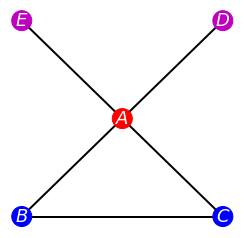

In [64]:
figure1, ax1 = plt.subplots(figsize = (4,4))
ax1.axis('off')
nx.draw_networkx_nodes(view_graph,pos,node_size=400,node_color= color)
nx.draw_networkx_edges(view_graph,pos,
                       edgelist= edges_list,
                       width=2.0,alpha=1)
# nx.draw_networkx_edges(pgm_explanation,pos,
#                        edgelist= pgm_explanation.edges,
#                        connectionstyle='arc3, rad = 0.2',
#                        width=2.0,alpha=0)
nx.draw_networkx_labels(view_graph,pos,labels,font_size=18, font_family = 'serif', font_weight = 'normal',
                        font_color = 'w')

# filename = 'view/motif_' + str(explained_node)+ '.jpg' 
# figure1.savefig(filename, dpi=90, bbox_inches='tight')

{300: Text(0,0,'$A$'),
 301: Text(-5,-5,'$B$'),
 302: Text(5,-5,'$C$'),
 303: Text(5,5,'$D$'),
 304: Text(-5,5,'$E$')}

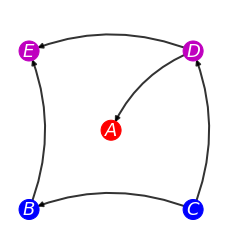

In [72]:
color_ = ['m','b','b','r','m']

figure2, ax = plt.subplots(figsize = (4,4))
ax.axis('off')
nx.draw_networkx_nodes(pgm_explanation,pos,node_size=400,node_color= color_)
nx.draw_networkx_edges(pgm_explanation,pos,
                       edgelist= pgm_explanation.edges,
                       connectionstyle='arc3, rad = 0.2',
                       width=2.0,alpha=0.8)
nx.draw_networkx_labels(pgm_explanation,pos,labels,font_size=18, font_family = 'serif', font_color = 'w')

# filename = 'view/pgm_' + str(explained_node)+ '.jpg' 
# figure2.savefig(filename, dpi=90, bbox_inches='tight')

In [70]:
p_a = explainer.pgm_conditional_prob(target, pgm_explanation, [300])
p_ab = explainer.pgm_conditional_prob(target, pgm_explanation, [300, 301])
p_abc = explainer.pgm_conditional_prob(target, pgm_explanation, [300, 301, 302])
p_abcd = explainer.pgm_conditional_prob(target, pgm_explanation, [300, 301, 302, 303])
print(p_a)
print(p_ab)
print(p_abc)
print(p_abcd)

0.47449016202751426
0.5398234392838551
0.5392915129633972
0.5510204081632653


In [71]:
p_b = explainer.pgm_conditional_prob(target, pgm_explanation, [301])
p_d = explainer.pgm_conditional_prob(target, pgm_explanation, [303])
p_bc = explainer.pgm_conditional_prob(target, pgm_explanation, [301,302])
print(p_b)
print(p_d)
print(p_bc)

0.5398990396172991
0.46693614906315495
0.5393668015729498
